In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Wall angle

In [2]:
codemap = cv2.imread('../sidegame/assets/maps/de_cache_code.png', cv2.IMREAD_COLOR)

In [3]:
walls = codemap[..., 1] == 255

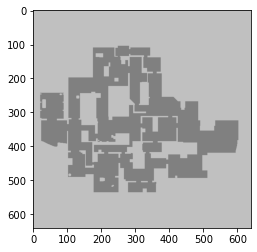

In [4]:
plt.imshow(walls, cmap='gray', vmin=-2, vmax=2);

In [5]:
# In direction of ascending indices
ver_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
hor_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

In [6]:
def apply_kernels(idx, idy):
    _, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    wall_chunk = walls[idy:idy+3, idx:idx+3]

    ver_mult = ver_kernel * wall_chunk
    hor_mult = hor_kernel * wall_chunk
    
    ax1.imshow(wall_chunk, cmap='gray', interpolation='nearest', vmin=-2, vmax=2)
    ax2.imshow(ver_mult, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
    ax3.imshow(hor_mult, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
    
    ax1.set_title('Wall chunk')
    ax2.set_title('Ver. mult.')
    ax3.set_title('Hor. mult.')

    return np.sum(ver_mult), np.sum(hor_mult)

(0, -3)

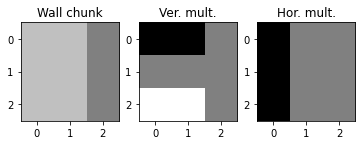

In [7]:
apply_kernels(174, 190)

(1, -3)

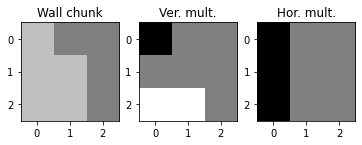

In [8]:
apply_kernels(422, 486)

(-2, 2)

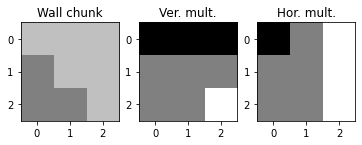

In [9]:
apply_kernels(419, 261)

(-2, 2)

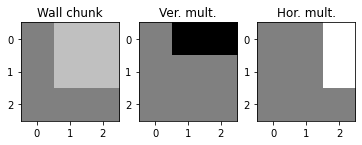

In [10]:
apply_kernels(377, 253)

In [11]:
def apply_kernels_2(idx, idy):
    """Wall angle def. wrt. ingoing normal, horizontal axis (angle 0), and ascending vertical direction (downward)."""

    wall_chunk = walls[idy-1:idy+2, idx-1:idx+2]

    ver_mult = ver_kernel * wall_chunk
    hor_mult = hor_kernel * wall_chunk
    
    sumy = np.sum(ver_mult)
    sumx = np.sum(hor_mult)
    
    asumy = abs(sumy)
    asumx = abs(sumx)

    wall_loc = None
    wall_angle = None

    if sumx == 0:
        if sumy < 0:
            wall_loc = 'above'
            wall_angle = -90.
        elif sumy > 0:
            wall_loc = 'below'
            wall_angle = 90
    elif sumy == 0:
        if sumx < 0:
            wall_loc = 'left'
            wall_angle = 180.
        elif sumx > 0:
            wall_loc = 'right'
            wall_angle = 0.
    elif sumx < 0 and sumy < 0:
        wall_loc = 'above-left'
        if asumx < asumy:
            wall_angle = -112.5
        elif asumx == asumy:
            wall_angle = -135.
        elif asumx > asumy:
            wall_angle = -157.5
    elif sumx < 0 and sumy > 0:
        wall_loc = 'below-left'
        if asumx < asumy:
            wall_angle = 112.5
        elif asumx == asumy:
            wall_angle = 135.
        elif asumx > asumy:
            wall_angle = 157.5
    elif sumx > 0 and sumy > 0:
        wall_loc = 'below-right'
        if asumx < asumy:
            wall_angle = 67.5
        elif asumx == asumy:
            wall_angle = 45.
        elif asumx > asumy:
            wall_angle = 22.5
    elif sumx > 0 and sumy < 0:
        wall_loc = 'above-right'
        if asumx < asumy:
            wall_angle = -22.5
        elif asumx == asumy:
            wall_angle = -45.
        elif asumx > asumy:
            wall_angle = -67.5

    print(wall_loc, '|', wall_angle)

    _, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(wall_chunk, cmap='gray', interpolation='nearest', vmin=-2, vmax=2)
    ax2.imshow(ver_mult, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
    ax3.imshow(hor_mult, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
    
    ax1.set_title('Wall chunk')
    ax2.set_title('Ver. mult.')
    ax3.set_title('Hor. mult.');

above | -90.0


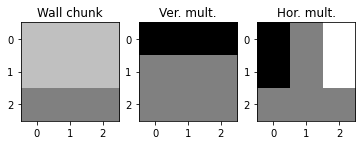

In [12]:
apply_kernels_2(247, 136)

below | 90


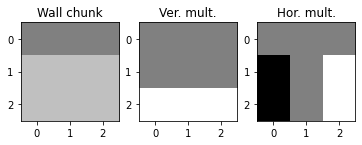

In [13]:
apply_kernels_2(247, 135)

left | 180.0


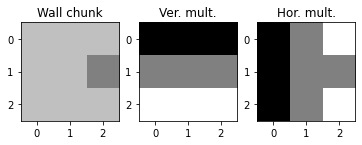

In [14]:
apply_kernels_2(422, 489)

right | 0.0


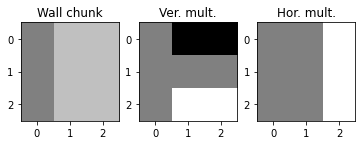

In [15]:
apply_kernels_2(432, 425)

below-left | 135.0


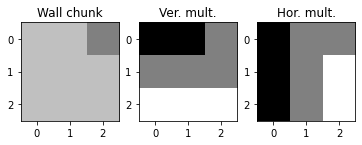

In [16]:
apply_kernels_2(422, 487)

above-right | -45.0


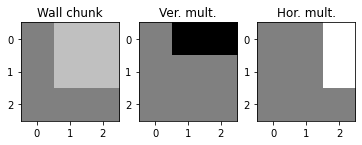

In [17]:
apply_kernels_2(378, 254)

above-right | -45.0


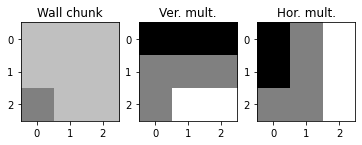

In [18]:
apply_kernels_2(432, 423)

above-left | -135.0


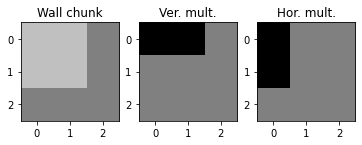

In [19]:
apply_kernels_2(248, 136)

below-right | 45.0


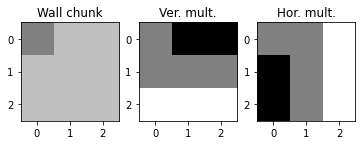

In [20]:
apply_kernels_2(282, 135)

above-right | -67.5


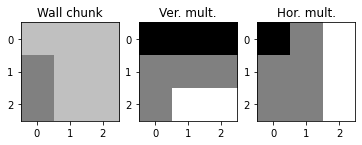

In [21]:
apply_kernels_2(432, 424)

above-left | -157.5


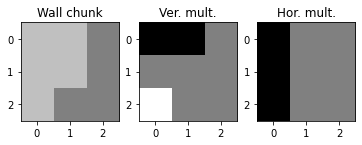

In [22]:
apply_kernels_2(423, 488)

above-left | -112.5


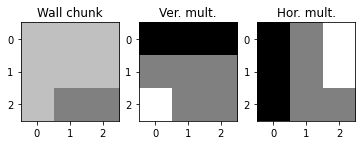

In [23]:
apply_kernels_2(532, 339)

above-right | -22.5


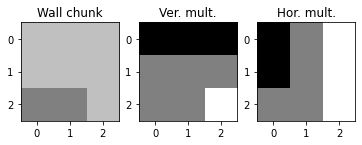

In [24]:
apply_kernels_2(511, 470)

below-left | 157.5


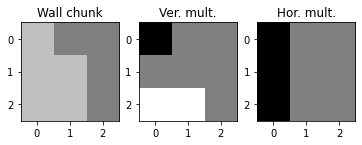

In [25]:
apply_kernels_2(423, 487)

below-right | 22.5


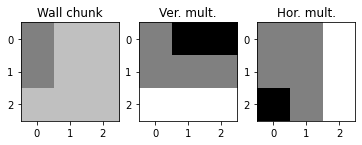

In [26]:
apply_kernels_2(600, 393)

below-left | 112.5


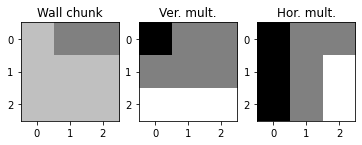

In [27]:
apply_kernels_2(423, 493)

below-left | 112.5


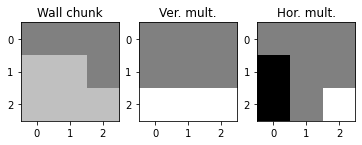

In [28]:
apply_kernels_2(51, 396)

below-right | 67.5


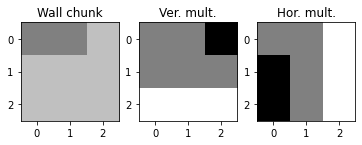

In [29]:
apply_kernels_2(602, 382)

### Wall deflection

In [30]:
def fix_angle_range(angle):
    angle %= 2.*np.pi

    if angle > np.pi:
        angle -= 2.*np.pi

    elif angle < -np.pi:
        angle += 2.*np.pi

    return angle

def wall_bounce(src_x, src_y, wall_x, wall_y, v_init=None, v_preservation=0.75):
    wall_chunk = walls[wall_y-1:wall_y+2, wall_x-1:wall_x+2]

    # Get correlations
    ver_mult = ver_kernel * wall_chunk
    hor_mult = hor_kernel * wall_chunk

    ver_correlation = np.sum(ver_mult)
    hor_correlation = np.sum(hor_mult)

    # Infer angle of wall's incoming normal
    wall_angle = np.arctan2(ver_correlation, hor_correlation)

    # Edge case handling was more intuitive under a different definition
    wall_angle -= np.pi/2.

    # Get difference relative to wall angle
    incoming_angle = np.arctan2(wall_y - src_y, wall_x - src_x)
    angle_diff = fix_angle_range(incoming_angle - wall_angle)

    # Handle edge cases
    if 0. < angle_diff < np.pi:
        print('Within 90 deg from the normal\n' + '-'*30)
        bounce_angle = 2.*wall_angle - incoming_angle
    elif -np.pi/4. < angle_diff <= 0.:
        print('Within 135 deg from the normal\n' + '-'*30)
        bounce_angle = 2.*wall_angle - incoming_angle - np.pi/2.
    elif (angle_diff == np.pi) or (-np.pi <= angle_diff < -3.*np.pi/4.):
        print('Within 135 deg from the normal\n' + '-'*30)
        bounce_angle = 2.*wall_angle - incoming_angle + np.pi/2.
    else:
        print('More than 135 deg from the normal\n' + '-'*30)
        bounce_angle = 2.*wall_angle - incoming_angle + np.pi

    bounce_angle = fix_angle_range(bounce_angle)

    print('Wall angle:     %.2f' % ((wall_angle + np.pi/2.) * 180./np.pi))
    print('Incoming angle: %.2f' % (incoming_angle * 180./np.pi))
    print('Bounce angle:   %.2f' % (bounce_angle * 180./np.pi))

    # Get new direction, set new target
    bounce_dir = np.array([np.cos(bounce_angle), np.sin(bounce_angle)])

    # Set new target
    v_init = np.linalg.norm([wall_y-src_y, wall_x-src_x]) if v_init is None else v_init
    v_new = v_init * v_preservation
    
    new_x, new_y = np.array([wall_x, wall_y]) + bounce_dir * v_new

    src_x, src_y = round(src_x), round(src_y)
    wall_x, wall_y = round(wall_x), round(wall_y)
    new_x, new_y = round(new_x), round(new_y)
    v_init = round(v_init)
    
    drawable_wall_chunk = walls.astype(np.float32)

    drawable_wall_chunk = walls.astype(np.float32)
    drawable_wall_chunk[src_y, src_x] = -2.
    drawable_wall_chunk[wall_y, wall_x] = -0.5
    drawable_wall_chunk[new_y, new_x] = 2.
    drawable_wall_chunk = drawable_wall_chunk[wall_y-1-v_init:wall_y+2+v_init, wall_x-1-v_init:wall_x+2+v_init]

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    
    ax1.imshow(wall_chunk, cmap='gray', interpolation='nearest', vmin=-2, vmax=2)
    ax2.imshow(drawable_wall_chunk, cmap='gray', interpolation='nearest', vmin=-2, vmax=2)
    
    ax1.set_title('Wall chunk')
    ax2.set_title('Bounce res.');

Within 90 deg from the normal
------------------------------
Wall angle:     90.00
Incoming angle: 53.13
Bounce angle:   -53.13


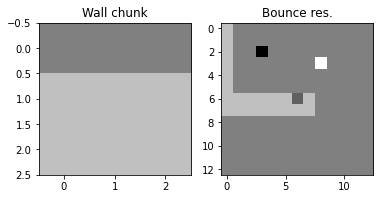

In [31]:
wall_bounce(244, 131, 247, 135)

Within 90 deg from the normal
------------------------------
Wall angle:     63.43
Incoming angle: 45.00
Bounce angle:   -98.13


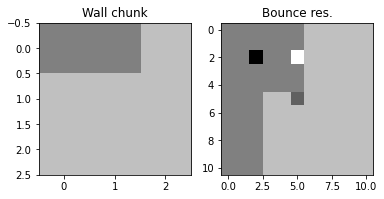

In [32]:
wall_bounce(599, 379, 602, 382)

Within 90 deg from the normal
------------------------------
Wall angle:     45.00
Incoming angle: 68.20
Bounce angle:   -158.20


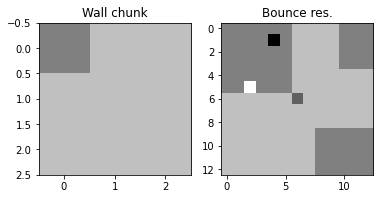

In [33]:
wall_bounce(280, 130, 282, 135)

Within 90 deg from the normal
------------------------------
Wall angle:     26.57
Incoming angle: -30.96
Bounce angle:   -95.91


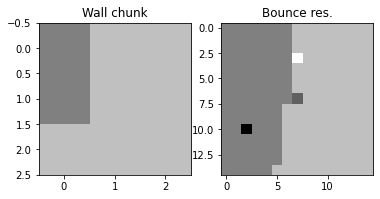

In [34]:
wall_bounce(595, 396, 600, 393)

Within 90 deg from the normal
------------------------------
Wall angle:     0.00
Incoming angle: -45.00
Bounce angle:   -135.00


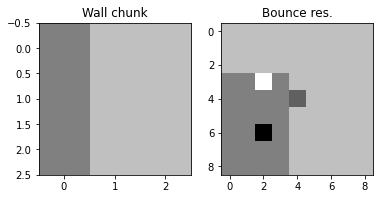

In [35]:
wall_bounce(430, 427, 432, 425)

Within 90 deg from the normal
------------------------------
Wall angle:     -26.57
Incoming angle: -45.00
Bounce angle:   171.87


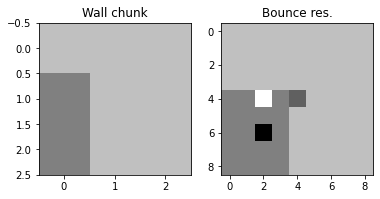

In [36]:
wall_bounce(430, 426, 432, 424)

Within 90 deg from the normal
------------------------------
Wall angle:     -45.00
Incoming angle: -26.57
Bounce angle:   116.57


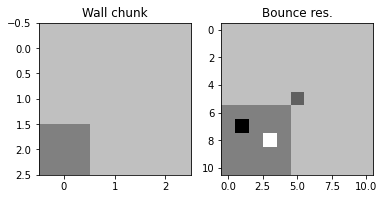

In [37]:
wall_bounce(428, 425, 432, 423)

Within 90 deg from the normal
------------------------------
Wall angle:     -45.00
Incoming angle: -90.00
Bounce angle:   180.00


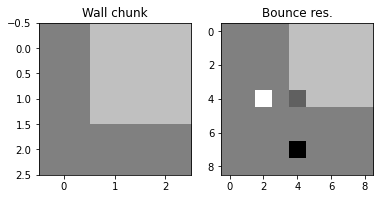

In [38]:
wall_bounce(378, 257, 378, 254)

Within 135 deg from the normal
------------------------------
Wall angle:     -45.00
Incoming angle: -135.00
Bounce angle:   135.00


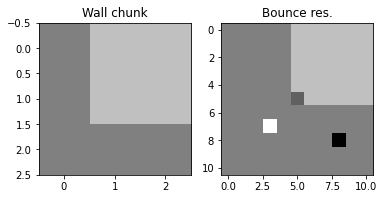

In [39]:
wall_bounce(381, 257, 378, 254)

Within 135 deg from the normal
------------------------------
Wall angle:     -45.00
Incoming angle: -158.20
Bounce angle:   158.20


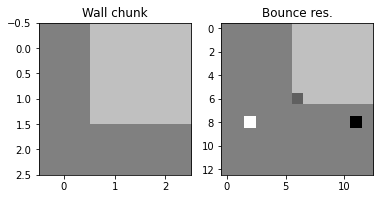

In [40]:
wall_bounce(383, 256, 378, 254)

More than 135 deg from the normal
------------------------------
Wall angle:     -45.00
Incoming angle: 172.87
Bounce angle:   97.13


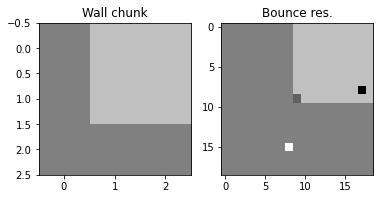

In [41]:
wall_bounce(386, 253, 378, 254)

Within 90 deg from the normal
------------------------------
Wall angle:     -63.43
Incoming angle: -68.20
Bounce angle:   121.33


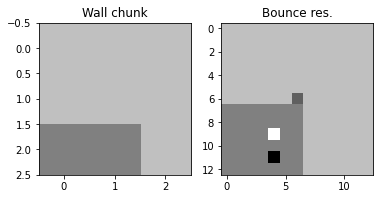

In [42]:
wall_bounce(509, 475, 511, 470)

Within 90 deg from the normal
------------------------------
Wall angle:     -90.00
Incoming angle: -33.69
Bounce angle:   33.69


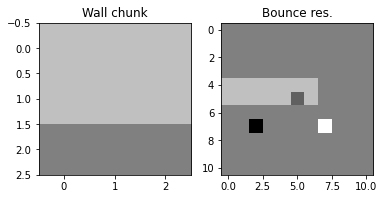

In [43]:
wall_bounce(244, 138, 247, 136)

Within 90 deg from the normal
------------------------------
Wall angle:     -116.57
Incoming angle: -161.57
Bounce angle:   108.43


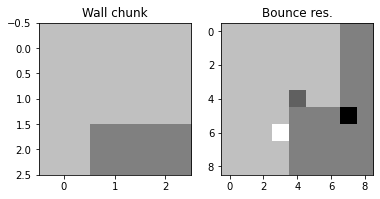

In [44]:
wall_bounce(535, 340, 532, 339)

Within 135 deg from the normal
------------------------------
Wall angle:     -135.00
Incoming angle: -18.43
Bounce angle:   18.43


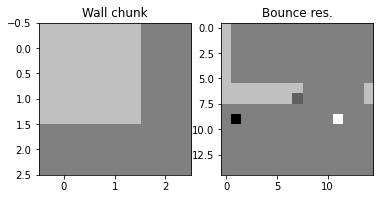

In [45]:
wall_bounce(242, 138, 248, 136)

More than 135 deg from the normal
------------------------------
Wall angle:     -135.00
Incoming angle: 9.46
Bounce angle:   80.54


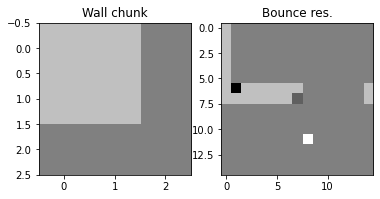

In [46]:
wall_bounce(242, 135, 248, 136)

Within 90 deg from the normal
------------------------------
Wall angle:     -161.57
Incoming angle: 180.00
Bounce angle:   36.87


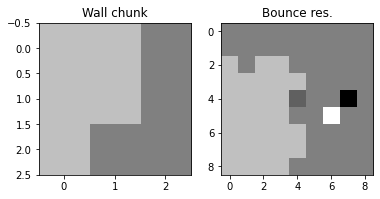

In [47]:
wall_bounce(426, 488, 423, 488)

Within 90 deg from the normal
------------------------------
Wall angle:     180.00
Incoming angle: 180.00
Bounce angle:   0.00


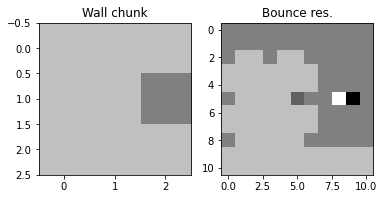

In [48]:
wall_bounce(426, 489, 422, 489)

Within 135 deg from the normal
------------------------------
Wall angle:     161.57
Incoming angle: -108.43
Bounce angle:   -18.43


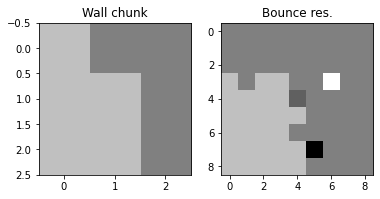

In [49]:
wall_bounce(424, 490, 423, 487)

Within 90 deg from the normal
------------------------------
Wall angle:     135.00
Incoming angle: 143.13
Bounce angle:   -53.13


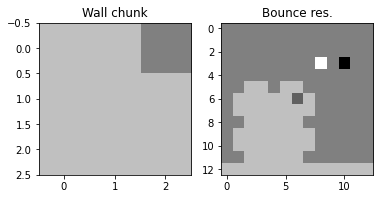

In [50]:
wall_bounce(426, 484, 422, 487)

Within 90 deg from the normal
------------------------------
Wall angle:     116.57
Incoming angle: 111.80
Bounce angle:   -58.67


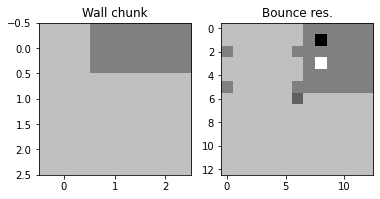

In [51]:
wall_bounce(425, 488, 423, 493)

Within 90 deg from the normal
------------------------------
Wall angle:     108.43
Incoming angle: 180.00
Bounce angle:   -143.13


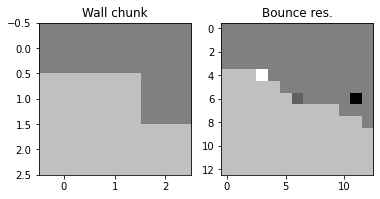

In [52]:
wall_bounce(56, 396, 51, 396)